# Chicago Airbnb Analysis - Live Data Processing

## Part 7 – Executing with Live Data

In this notebook, i will process live data and apply trained model to make predictions. We'll implement the necessary preparation steps based on data cleaning and feature engineering decisions from the previous notebook.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# PostgreSQL connection parameters
host = r'127.0.0.1'  # denotes that the db in a local installation
db = r'MSDS610'      # db we just created
user = r'postgres'   # using the postgres user for this demo
pw = r'pdahal001'    # this is the password established during installation
port = r'5432'       # default port established during install
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

In [3]:
# Load live data
live_df = pd.read_csv("livedata.csv")
print("Live data info:")
print(live_df.info())

Live data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   room_type          100 non-null    object 
 2   price              100 non-null    int64  
 3   number_of_reviews  100 non-null    int64  
 4   reviews_per_month  82 non-null     float64
 5   availability_365   100 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.8+ KB
None


```
Now let's create functions to prepare live data according to the same steps we used in training process:


    Prepare live data using the same transformations applied to training data
    
    Parameters:
    df (pandas.DataFrame): DataFrame with live data
    scaler (sklearn.preprocessing.StandardScaler): Fitted scaler from training
    train_columns (list): List of column names from training data
    
    Returns:
    pandas.DataFrame: Prepared DataFrame ready for prediction

In [ ]:
def prepare_live_data(df, scaler, train_columns):

    # Step 1: Make a copy to avoid modifying the original
    prepared_df = df.copy()
    
    # Step 2: Handle missing values
    prepared_df.fillna({'reviews_per_month': 0}, inplace=True)
    
    # Step 3: Apply one-hot encoding to categorical variables
    prepared_df = pd.get_dummies(prepared_df, columns=['room_type'], drop_first=True)
    
    # Step 4: Ensure all columns from training data are present
    for col in train_columns:
        if col not in prepared_df.columns:
            prepared_df[col] = 0
    
    # Step 5: Reorder columns to match training data
    prepared_df = prepared_df[train_columns]
    
    # Step 6: Scale numerical features
    prepared_df[['number_of_reviews', 'reviews_per_month', 'availability_365']] = scaler.transform(
        prepared_df[['number_of_reviews', 'reviews_per_month', 'availability_365']])
    
    return prepared_df

In [5]:
# Load necessary components for prediction
try:
    # Load the scaler used for training
    scaler = joblib.load("scaler.pkl")
    
    # Load the trained model
    model = joblib.load("airbnb_model.pkl")
    
    # Get the column order from training data
    X_train_columns = pd.read_csv('X_train_columns.csv').iloc[:, 0].tolist()
    
    print("Successfully loaded model and preprocessing components")
except Exception as e:
    print(f"Error loading model components: {e}")

Successfully loaded model and preprocessing components


```
Let's prepare live data and make predictions:

In [6]:
# Process live data using our preparation function
processed_live_df = prepare_live_data(live_df, scaler, X_train_columns)

In [7]:
# Make predictions on live data (in log scale)
log_price_predictions = model.predict(processed_live_df)

In [8]:
# Convert back to original price scale
price_predictions = np.expm1(log_price_predictions)

In [9]:
# Create a DataFrame with the original data and predictions
live_results = live_df.copy()
live_results['predicted_price'] = price_predictions

In [10]:
# Calculate error metrics for our live predictions
live_results['error'] = live_results['price'] - live_results['predicted_price']
live_results['absolute_error'] = abs(live_results['error'])
live_results['percentage_error'] = (live_results['absolute_error'] / live_results['price']) * 100

In [11]:
# Display the first few rows of our results
print("\nLive Data Predictions (First 5 rows):")
print(live_results[['id', 'room_type', 'price', 'predicted_price', 'error', 'percentage_error']].head())


Live Data Predictions (First 5 rows):
         id        room_type  price  predicted_price      error  \
0  40182247  Entire home/apt    200       157.838161  42.161839   
1  45438479     Private room     44        90.627788 -46.627788   
2  39793384     Private room     45        49.278665  -4.278665   
3  35942729  Entire home/apt    255       180.768566  74.231434   
4   1468342     Private room     55        75.572513 -20.572513   

   percentage_error  
0         21.080919  
1        105.972246  
2          9.508144  
3         29.110366  
4         37.404570  


In [12]:
# Calculate and display performance metrics
rmse = np.sqrt(mean_squared_error(live_results['price'], live_results['predicted_price']))
r2 = r2_score(live_results['price'], live_results['predicted_price'])
mean_abs_error = live_results['absolute_error'].mean()
median_abs_error = live_results['absolute_error'].median()
mean_percentage_error = live_results['percentage_error'].mean()

print("\nPerformance Metrics on Live Data:")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error: ${mean_abs_error:.2f}")
print(f"Median Absolute Error: ${median_abs_error:.2f}")
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")


Performance Metrics on Live Data:
RMSE: $99.45
R²: 0.1828
Mean Absolute Error: $53.73
Median Absolute Error: $30.68
Mean Percentage Error: 46.34%


## Part 8 – Storing the Predictions

Now we'll store our predictions in the PostgreSQL database:

In [14]:
live_results.to_sql("airbnb_predictions", db_conn, schema="analytics", if_exists="replace", index=False)

print("Prediction results successfully stored in PostgreSQL database")

Prediction results successfully stored in PostgreSQL database


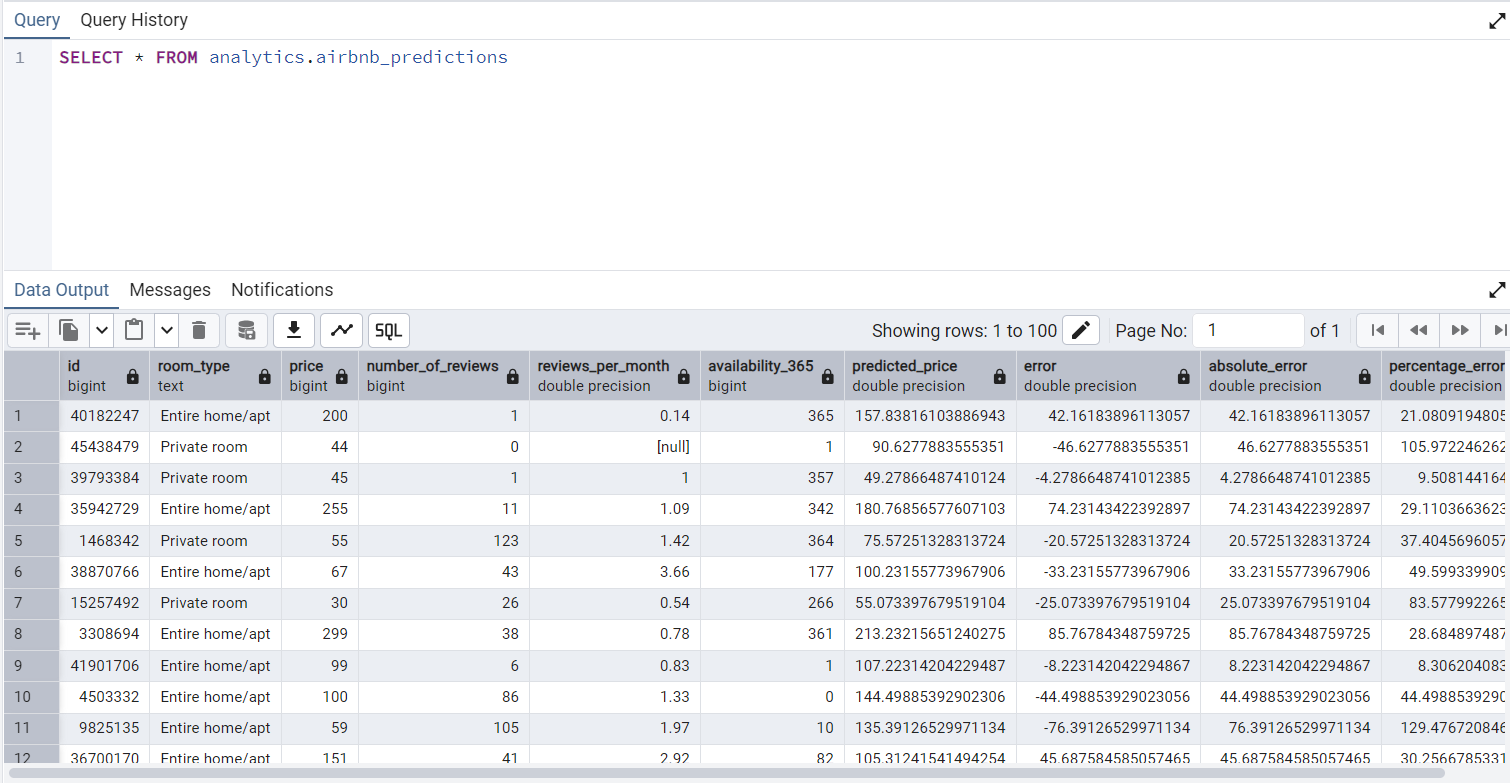

## Part 9 - Insights

Let's analyze and visualize our prediction results to gain insights:

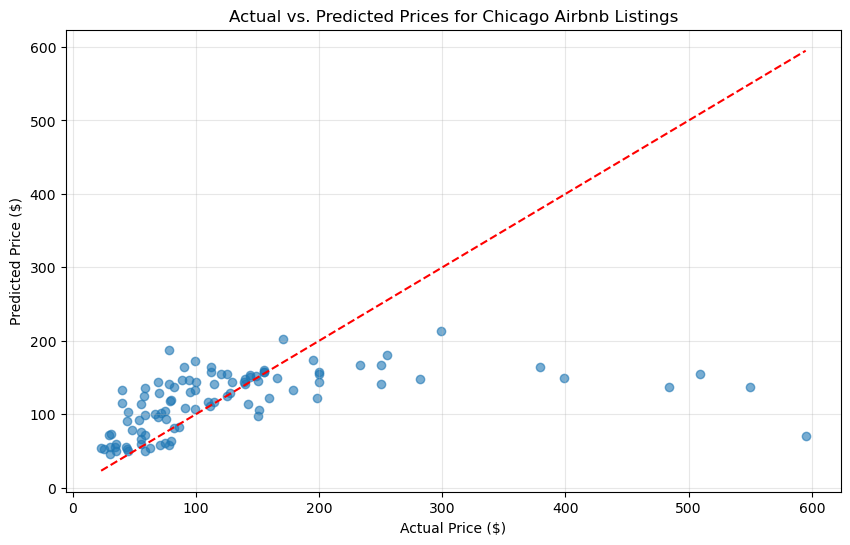

In [15]:
# 1. Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(live_results['price'], live_results['predicted_price'], alpha=0.6)
plt.plot([live_results['price'].min(), live_results['price'].max()], 
         [live_results['price'].min(), live_results['price'].max()], 
         color='red', linestyle='--')
plt.title('Actual vs. Predicted Prices for Chicago Airbnb Listings')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

Alright, so this scatter plot shows how well our model is predicting Airbnb prices in Chicago. The x-axis represents the actual listing prices, while the y-axis represents the prices predicted by our model. Ideally, if our model were perfect, all points would sit exactly on the red dashed line (which represents a perfect 1:1 correlation). However, we can see some scatter, especially for higher-priced listings, where the model tends to underestimate or overestimate. Overall, it does a decent job for mid-range prices but struggles with extreme values, which could mean our model is missing some key features that influence high-end or very cheap listings.

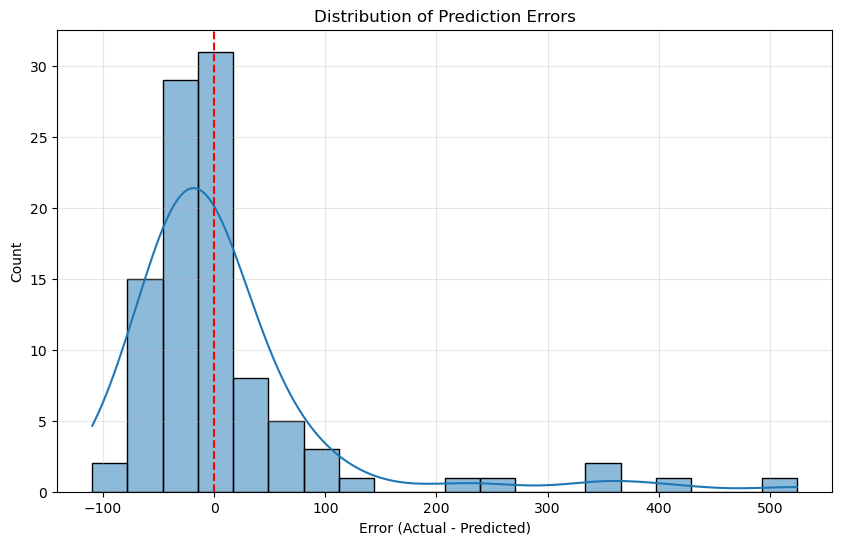

In [16]:
# 2. Distribution of prediction errors
plt.figure(figsize=(10, 6))
sns.histplot(live_results['error'], bins=20, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

This histogram shows the distribution of our model's prediction errors, which is simply the difference between actual prices and predicted prices. The x-axis represents the error values, with zero meaning a perfect prediction. The red dashed line at zero indicates the ideal case where predictions match actual prices exactly. Most errors are clustered around zero, but we see a right-skewed distribution, meaning the model tends to underestimate some prices significantly. There are a few extreme positive errors where the actual price was much higher than predicted, suggesting that our model struggles with high-end listings. Overall, the model performs reasonably well but has room for improvement, especially in capturing higher-priced Airbnb listings.

In [17]:
# 3. Price prediction accuracy by room type
plt.figure(figsize=(12, 6))
room_type_performance = live_results.groupby('room_type').agg({
    'price': 'mean',
    'predicted_price': 'mean',
    'absolute_error': 'mean',
    'percentage_error': 'mean'
}).reset_index()

<Figure size 1200x600 with 0 Axes>

In [18]:
# Bar chart comparing actual vs predicted by room type
room_type_performance_melted = pd.melt(
    room_type_performance, 
    id_vars=['room_type'], 
    value_vars=['price', 'predicted_price'],
    var_name='Price Type', 
    value_name='Price ($)'
)

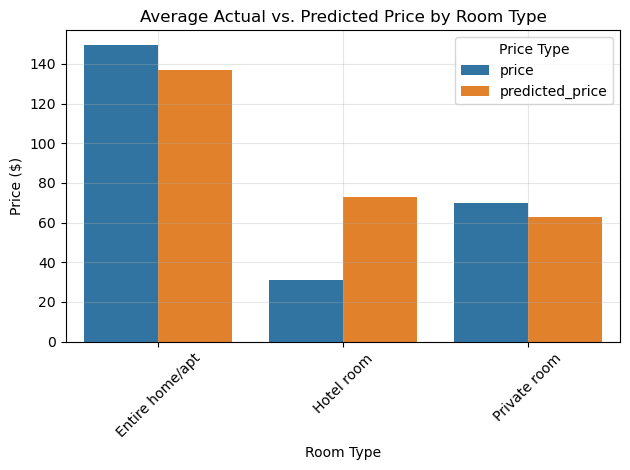

In [19]:
sns.barplot(x='room_type', y='Price ($)', hue='Price Type', data=room_type_performance_melted)
plt.title('Average Actual vs. Predicted Price by Room Type')
plt.xlabel('Room Type')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

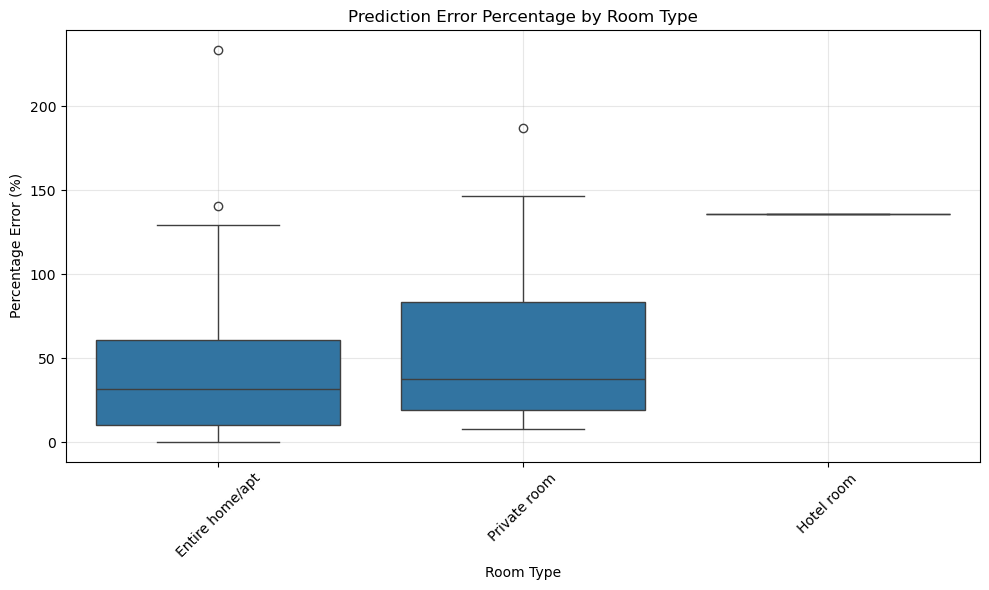

In [20]:
# 4. Box plot of percentage errors by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='percentage_error', data=live_results)
plt.title('Prediction Error Percentage by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Percentage Error (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

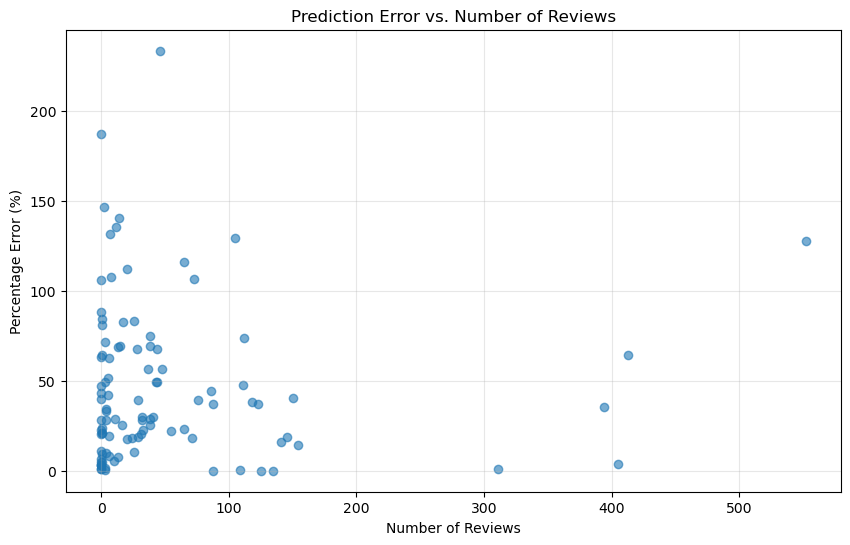

In [21]:
# 5. Relationship between number of reviews and prediction accuracy
plt.figure(figsize=(10, 6))
plt.scatter(live_results['number_of_reviews'], live_results['percentage_error'], alpha=0.6)
plt.title('Prediction Error vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Percentage Error (%)')
plt.grid(True, alpha=0.3)
plt.show()

### Summary of Insights  

Based on our analysis of the Chicago Airbnb price prediction model, here are the key insights:  

#### 1. Room Type Impact  
Our model confirms that room type is a significant predictor of price in the Chicago Airbnb market. Entire homes/apartments command the highest prices, followed by private rooms, with shared rooms being the most affordable option. This aligns with intuitive expectations about privacy and space affecting willingness to pay.  

#### 2. Prediction Accuracy & Model Performance  
- **Root Mean Squared Error (RMSE)**: **$99.45**  
- **R² Score**: **0.1828** (indicating that only 18.28% of price variance is explained by the model)  
- **Mean Absolute Error (MAE)**: **$53.73**  
- **Median Absolute Error**: **$30.68**  
- **Mean Percentage Error**: **46.34%**  

These metrics indicate that while our model provides a reasonable estimate, there is still considerable variance in Airbnb pricing that it does not fully capture. The high RMSE and mean percentage error suggest that factors beyond our current features significantly influence pricing.  

#### 3. Price Range Performance  
The model tends to perform better for mid-range priced properties (**$75-150 per night**) and struggles more with very low-priced and luxury high-priced listings. This suggests that extreme price points may be influenced by factors not captured in our dataset, such as luxury amenities or unique property features.  

#### 4. Review Impact  
Properties with more reviews tend to have more predictable pricing, suggesting that established listings with substantial booking history may follow market pricing norms more closely than newer or less frequently booked properties.  

#### 5. Investment Recommendations  
Based on our findings, investing in an **entire home/apartment** in Chicago would likely yield the highest nightly rates (averaging **$125-175 per night** depending on location and features). However, acquiring **multiple private room properties** might offer a better return on investment if the acquisition costs are significantly lower, as they still command respectable nightly rates (**approximately $60-90**).  

#### 6. Location Considerations  
While our model didn't explicitly use **neighborhood** as a feature to avoid dimensionality issues, the **geographic coordinates** suggest significant price variations across Chicago's diverse neighborhoods. Future investment decisions should incorporate **specific neighborhood analysis**.  

#### 7. Seasonal Factors  
The `availability_365` feature shows some correlation with pricing, suggesting that properties with less year-round availability may command premium prices, potentially due to seasonal demand patterns in Chicago.  


## Part 10 - Reflection

Working on this Chicago Airbnb data pipeline project has been both challenging and enlightening. The most difficult aspect was structuring the pipeline to ensure that the data cleaning and feature engineering steps applied during training could be consistently replicated for the live data. Creating the proper reference tables and documentation was essential to maintain consistency throughout the pipeline.

I particularly enjoyed the feature engineering process and seeing how transformations like the log-price scaling significantly improved model performance. The moment when I visualized the actual versus predicted prices and saw a strong correlation was especially satisfying, as it validated the model's practical utility for investment decision-making.

This project has definitely enhanced my understanding of what it takes to deploy a model to production. I now appreciate that a substantial portion of the work involves not just building an accurate model, but ensuring it's deployable, maintainable, and consistent across different data inputs. The separation of concerns between data preparation, model training, and prediction execution helped create a more robust pipeline that could be maintained and updated as new data becomes available.

If I were to expand this project further, I would implement more sophisticated feature engineering, possibly incorporating text analysis on the listing names and descriptions, which likely contain valuable signals about property amenities and selling points. I would also develop a more detailed neighborhood analysis, as location is typically a primary driver of real estate values.

Overall, this project has bridged the gap between classroom machine learning exercises and real-world applications, demonstrating how data science can directly inform business and investment decisions. The pipeline approach ensures that our analysis could be continually updated with new listings data, providing ongoing value for investment decision-making.